In [1]:
import pandas as pd
import numpy as np
import seaborn as sn

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import xgboost
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
seed = 101

/Users/yahya/anaconda/envs/deeplearningkeras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yahya/anaconda/envs/deeplearningkeras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yahya/anaconda/envs/deeplearningkeras/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading and Preprocessing of data

In [2]:
data = pd.read_csv('input/data_challenge.csv',index_col=0)

In [3]:
data = shuffle(data,random_state=seed)
data.head()

,DX,AGE,MONTH,SEX,Absent,Present
9697,c_0036,38.0,2,0,s_0553,"s_0542, s_0290, s_0837, s_0084, s_1266, s_0180"
31843,c_0499,55.0,8,0,NaN,"s_1547, s_0653"
63932,c_0152,35.0,10,0,"s_0070, s_0653, s_0039, s_0078, s_2734, s_0837...","s_1611, s_0445, s_0542, s_0084, s_0315, s_0478..."
69507,c_0145,26.0,6,1,"s_0106, s_0542, s_0124, s_0084, s_0180","s_0136, s_0290, s_2734"
64367,c_0036,61.0,4,0,"s_0070, s_0180, s_0553, s_0039, s_1611, s_0136...","s_0227, s_0078, s_0786, s_0084, s_0356, s_0739"


According to the information we get from data, we can see that out of all fields in data, only 'Present' and 'Absent' have null values, and among these two, not having information for 'Present' means that no symtoms are recorded for the patient making the job of diagnosis meaningless. That is why the rows that are null for 'Present' are removed from data.

In [4]:
data.info()
data.dropna(subset=['Present'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71662 entries, 9697 to 45919
Data columns (total 6 columns):
DX         71662 non-null object
AGE        71662 non-null float64
MONTH      71662 non-null int64
SEX        71662 non-null int64
Absent     64343 non-null object
Present    66392 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 3.8+ MB


# Exploratory Data Analysis

The following bar plot shows how imbalanced the dataset is as we can see number of total patients diagnosed with a specific deseese vary from over tens of thousands for classes like c_0608 amd c_0145 to under 100 for classes like c_0184 and c_0498. This makes multiclass classification job and its evaluation alot more challenging.

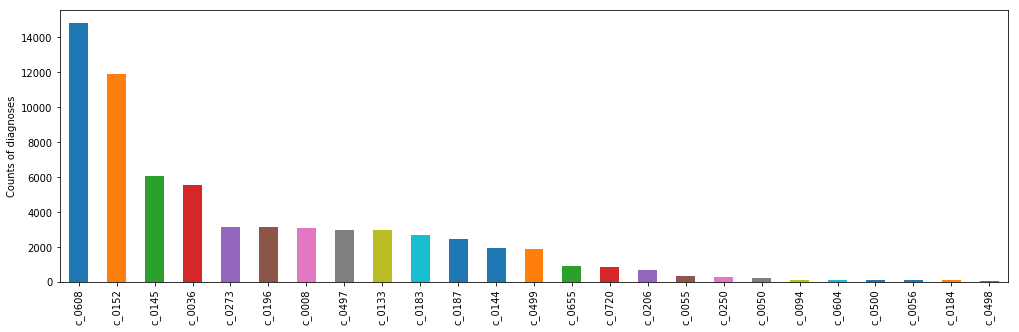

In [5]:
plt.figure(figsize=(17, 5))
plt.ylabel("Counts of diagnoses")
data['DX'].value_counts().plot(kind='bar')

To see which features can help us in predicting classes, we can take a look at how their distribution varies per class. The following side by side histogram of age for 5 classes with highest number of patients shows this difference that can help in prediction. For instance, c_0145 is seen more in patients under 5 while c_0273 is seen in patients over 30. 

Text(0.5,1,'Side-by-Side Histogram with Multiple Diagnoses')

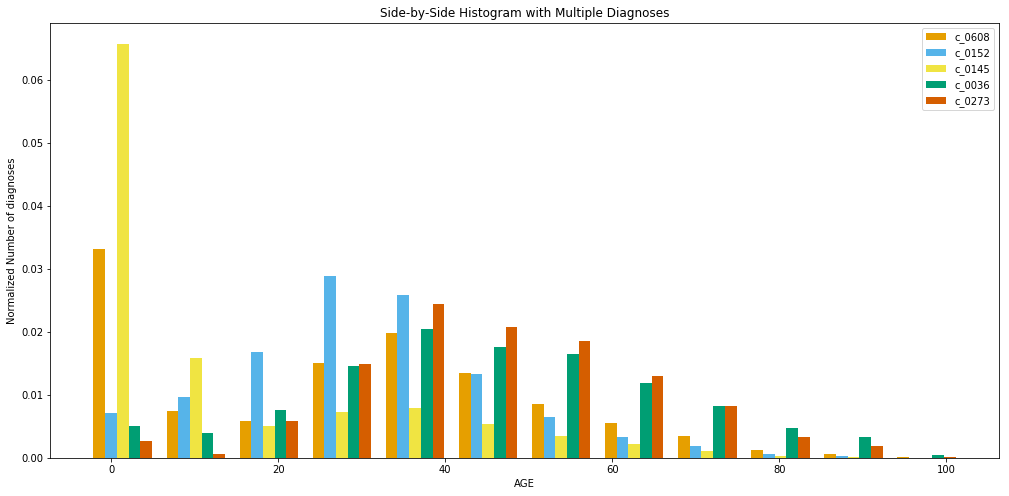

In [6]:
x1 = list(data[data['DX'] == 'c_0608']['AGE'])
x2 = list(data[data['DX'] == 'c_0152']['AGE'])
x3 = list(data[data['DX'] == 'c_0145']['AGE'])
x4 = list(data[data['DX'] == 'c_0036']['AGE'])
x5 = list(data[data['DX'] == 'c_0273']['AGE'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['c_0608', 'c_0152', 'c_0145', 'c_0036', 'c_0273']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.figure(figsize=(17, 8))
plt.hist([x1, x2, x3, x4, x5], bins = int(180/15), density=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('AGE')
plt.ylabel('Normalized Number of diagnoses')
plt.title('Side-by-Side Histogram with Multiple Diagnoses')

Side by side histogram of Month for some classes also shows existense of a different seasonality for some desease. This indicates that month of diagnosis can also be helpful in prediction.

Text(0.5,1,'Side-by-Side Histogram with Multiple Diagnoses')

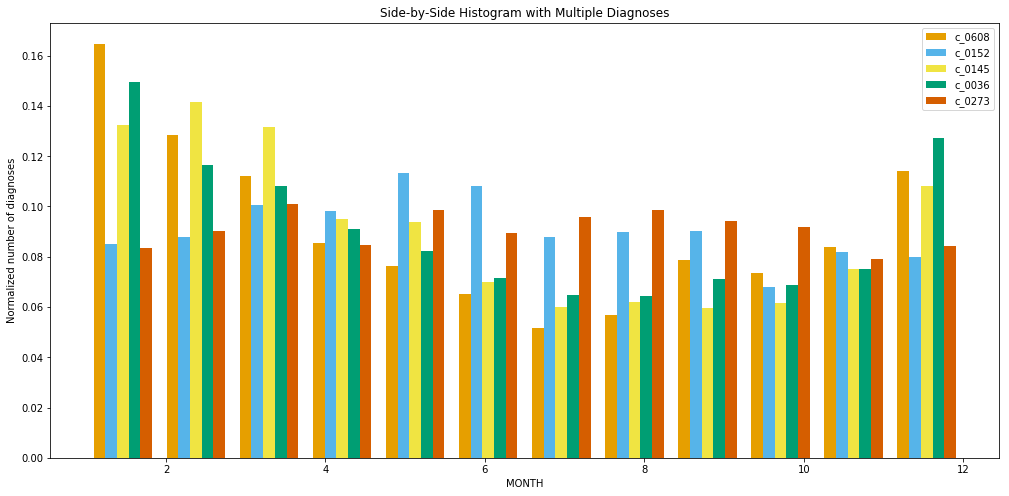

In [7]:
x1 = list(data[data['DX'] == 'c_0608']['MONTH'])
x2 = list(data[data['DX'] == 'c_0152']['MONTH'])
x3 = list(data[data['DX'] == 'c_0145']['MONTH'])
x4 = list(data[data['DX'] == 'c_0036']['MONTH'])
x5 = list(data[data['DX'] == 'c_0273']['MONTH'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['c_0608', 'c_0152', 'c_0145', 'c_0036', 'c_0273']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.figure(figsize=(17, 8))
plt.hist([x1, x2, x3, x4, x5], bins = int(180/15), density=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('MONTH')
plt.ylabel('Normalized number of diagnoses')
plt.title('Side-by-Side Histogram with Multiple Diagnoses')

Bar plot of sex across different classes also indicates how variable this distribution is from c_0050 and c_0152 that are more diagnosed for males (that can also be because of a larger number of male patients in dataset) to c_0498 of which a similar number of patients of different sexes are diagnosed.

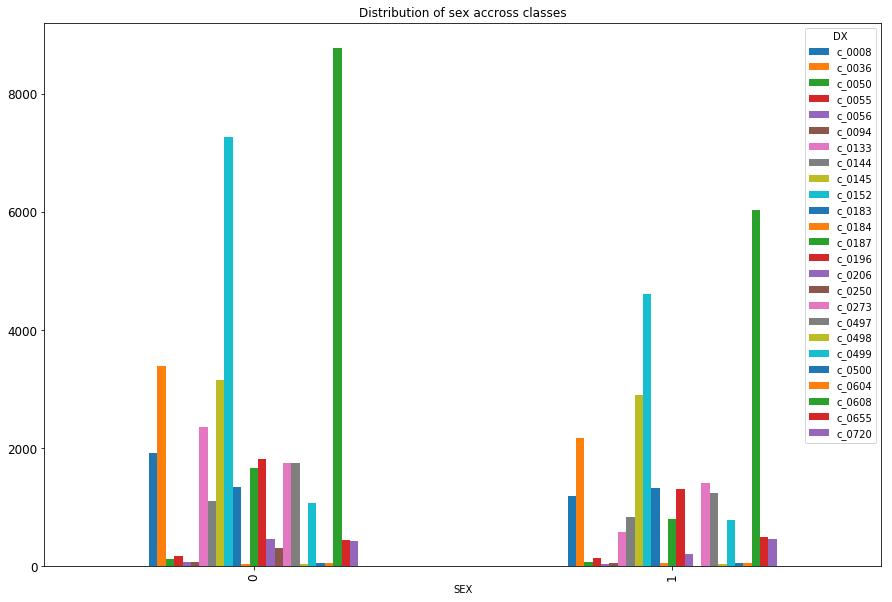

In [8]:
data_sample = data[['DX','SEX']].pivot_table(index='SEX', columns=['DX'], aggfunc=len, fill_value=0)
data_sample.plot(kind='bar', title ="Distribution of sex accross classes", figsize=(15, 10), legend=True, fontsize=12)

# Preparation of Train and Test Data

In [9]:
Y = data['DX']
X = data.drop('DX',axis=1)

In [10]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

20 percent of data is randomly sample to be used as test data for evaluation.

In [11]:
test_size = 0.2
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)

Sample weights will be used later to deal with imbalanceness of data.

In [12]:
from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight('balanced', y_train)
sample_weights

array([0.44159634, 0.48033461, 0.22190516, ..., 0.17920877, 1.42680994,
       2.8364753 ])

# Feature Engineering

AGE as a numeric feature needs to be normalized and for that I use standard normalization. For test data 'AGE' is normalized using mean and std that are extracted from training data assuming model has no information about test data.

In [13]:
std = np.std(x_train['AGE'])
mean = np.mean(x_train['AGE'])
x_train['AGE'] -= mean
x_train['AGE'] /= std

In [14]:
x_test['AGE'] -= mean
x_test['AGE'] /= std

Month is an oridnal feature, but is also cyclic, so the best way of representing it is converting it to a circular variable using two features of MONTH_X and MONTH_Y.

In [15]:
month_circum = 12
x_train = pd.concat([x_train, x_train['MONTH'].apply(lambda var:pd.Series({'MONTH_x':np.sin(2 * np.pi * var / month_circum),'MONTH_y':np.cos(2 * np.pi * var / month_circum)}))], axis=1)
x_train.drop('MONTH',axis=1,inplace=True)

In [16]:
x_test = pd.concat([x_test, x_test['MONTH'].apply(lambda var:pd.Series({'MONTH_x':np.sin(2 * np.pi * var / month_circum),'MONTH_y':np.cos(2 * np.pi * var / month_circum)}))], axis=1)
x_test.drop('MONTH',axis=1,inplace=True)

Two features of 'Present' and 'Absent' are lists of symptoms that need to be one-hot encoded together, and that is because symproms that are present for a patient are not absent for him/her but also there are symptoms that are neither present nor absent. For that reason, I first extracted all existing sysmptoms in training data that have been present or absent for different patients. Then of all these extracted symptoms, the ones that are present for each patient are encoded to 1, ones that are absent are encoded to -1 and the remaining ones that are ones that are not aksed for remain zero.

In [17]:
present_symptoms = np.array(x_train['Present'])
absent_symptoms = np.array(x_train['Absent'].dropna())
present_absent_symptoms = np.concatenate((present_symptoms,absent_symptoms),axis=0)

In [18]:
token_index = {}
symptoms = []
for i,seq in enumerate(present_absent_symptoms):
    for word in seq.split(','):
        word = word.strip()
        if word not in symptoms:
            symptoms.append(word)
            token_index[word] = len(token_index) + 1

In [19]:
print(f"There exists {len(symptoms)} number of symptoms in training data")

There exists 726 number of symptoms in training data


In [20]:
present_samples = np.array(x_train['Present'])
absent_samples = np.array(x_train['Absent'])

In [21]:
present_samples

array(['s_0400, s_2742, s_0106, s_0084', 's_2742, s_0605, s_0553, s_0777',
       's_0445, s_0180', ..., 's_0445, s_0864, s_0084', 's_0824',
       's_0270, s_0954, s_1759'], dtype=object)

In [22]:
def one_hot(present_samples,absent_samples):
    results = np.zeros(shape=(len(present_samples),max(token_index.values()) + 1))
    for i, sample in enumerate(absent_samples):
        if sample == '' or pd.isnull(sample):
            pass
        else:
            for j, word in list(enumerate(sample.split(','))):
                word = word.strip()
                index = token_index.get(word,None)
                if index:
                    results[i, index] = -1
    for i, sample in enumerate(present_samples):
        for j, word in list(enumerate(sample.split(','))):
            word = word.strip()
            index = token_index.get(word,None)
            if index:
                results[i, index] = 1
    return results

In [23]:
encoded_symptoms =  one_hot(present_samples,absent_samples)

In [24]:
x_train.drop(columns=['Present','Absent'],axis=1,inplace=True)

In [25]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [26]:
x_train.shape

(53113, 4)

In [27]:
encoded_symptoms.shape

(53113, 727)

In [28]:
x_train = np.concatenate((x_train,encoded_symptoms),axis=1)

In [29]:
x_train.shape

(53113, 731)

The same symptoms that are extracted from training data with its corresponding token index will be used to one hot encode the test data. The sysmptoms that happen to exist in test data that did not appear in any of patients in training data will be treated as not asked and encoded to zero.

In [31]:
test_present_samples = np.array(x_test['Present'])
test_absent_samples = np.array(x_test['Absent'])
test_results =  one_hot(test_present_samples,test_absent_samples)
x_test.drop(columns=['Present','Absent'],axis=1,inplace=True)
x_test = np.array(x_test)
x_test = np.concatenate((x_test,test_results),axis=1)

# Training using XGBOOST model without handling imbalanced data

I decided to use XGBoost mode for prediction that is one of the most popular models that is tree based and represents both speed and performance and also have ways of handling imbalanced datasets. I first trained it on training data and then generated predictions for the test data.

In [30]:
# fit model to training data
model = xgboost.XGBClassifier()
model.fit(x_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


Notice how the XGBoost model is configured to automatically model the multiclass classification problem using the multi:softprob objective, a variation on the softmax loss function to model class probabilities. This suggests that internally, that the output class is converted into a one hot type encoding automatically.

In [32]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

# Evaluation of XGBOOST model without handling imbalanced data

First I use simple accuracy metric to evaluate the trained model on test data that gives me accuracy of around 61.5%. However, since the dataset is highly imbalanced it is better to evaluate model using other criteria like confusion matrix or f1score.

In [33]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.49%


In [34]:
class_names = np.unique(y_train)
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, range(25),range(25))
le_name_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
df_cm.index = df_cm.index.map(le_name_mapping)
df_cm.columns = df_cm.columns.map(le_name_mapping)

Confusion matrix shows how the model has performed across different classes. In the following heatmap of normalized confusion matrix, diagonal pixels show accuracy for different classes where brighter colors indicate higher accuracy and darker colors show lower accuracy. As you can see these accuracies are all around the place from being high for classes like c_0133 that has thousands of samples to almost zero for classes like c_0500 that have few samples. It means that model has done poorly across classes with fewer number of data points even though the overall f1score is 61.5%. However, if we are looking for a model that overall performs well for classes that have good number of points, this model can be a good selection since it also results in over 67% of weighted accuracy.

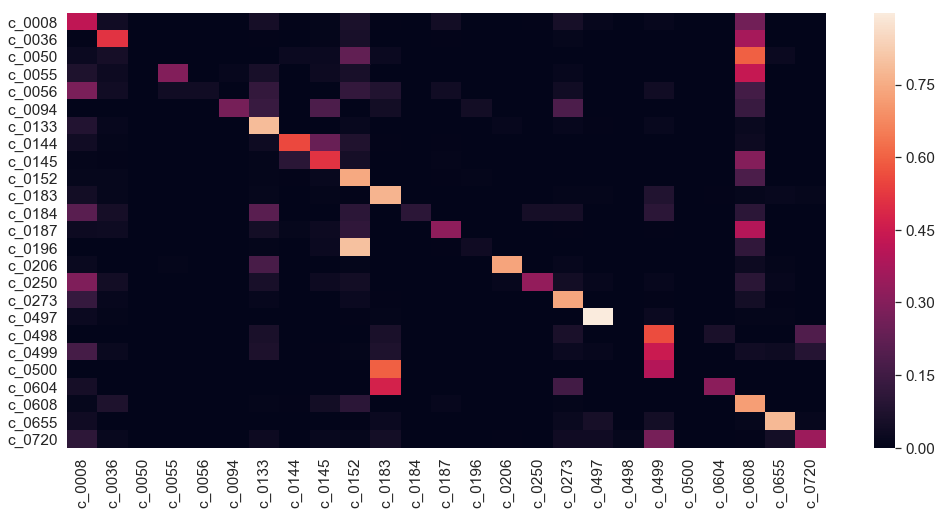

In [35]:
plt.figure(figsize=(17, 8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=False,annot_kws={"size": 16})# font size

In [36]:
pd.Series(np.diag(df_cm), index=[df_cm.index])

c_0008    0.424191
c_0036    0.513561
c_0050    0.000000
c_0055    0.295775
c_0056    0.040000
c_0094    0.272727
c_0133    0.788779
c_0144    0.555556
c_0145    0.512903
c_0152    0.744156
c_0183    0.771800
c_0184    0.105263
c_0187    0.321012
c_0196    0.035473
c_0206    0.736434
c_0250    0.333333
c_0273    0.738510
c_0497    0.898251
c_0498    0.000000
c_0499    0.446866
c_0500    0.000000
c_0604    0.315789
c_0608    0.720313
c_0655    0.779570
c_0720    0.349398
dtype: float64

In [37]:
print("Micro average f1 score: {:.3f}".format (f1_score(y_test, predictions, average="micro")))

Micro average f1 score: 0.615


The resulting class weighted accuracy is:

In [38]:
w = np.ones(y_test.shape[0])
for idx, i in enumerate(np.bincount(y_test)):
    w[y_test == idx] *= (i/float(y_test.shape[0]))
accuracy_score(y_test, predictions, sample_weight=w)

0.6759784298363919

# Training and evaluation of XGBoost model with imbalanced data handling

One way to handle imbalanced data is using xgboost model that internally takes care that the bags it trains on are not imbalanced. For that I added a hyper parameter sample weight providing each instance a weight to differentiate the importance of instances based on their class, so that xgboost could design a cost function that is penalizing wrong classification of the rare class more than wrong classifications of the abundant class. After training the model and doing prediction on test data the overall accuracy seems lower but in fact when looking across different classes, the overall per class accuracy has improved.

In [39]:
# fit model to training data with sample weights
model = xgboost.XGBClassifier()
model.fit(x_train, y_train, sample_weight=sample_weights)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [40]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [41]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.73%


In [42]:
print("Micro average f1 score: {:.3f}".format (f1_score(y_test, predictions, average="micro")))

Micro average f1 score: 0.517


If we look at heatmap of normalized confusion matrix we can see that for diagonal pixels that represent per class accuracy, now there no longer exists a completely dark pixel and all accuracies are more than 30% with 15 classes having accuracy higher that 50% while in previouse approach without using sample weights, there existed 8 classes lower that 30% and only 11 above 50. That concludes that by using xgboost model that handles imbalanced classes, we could improve accuracy accross different classes. 

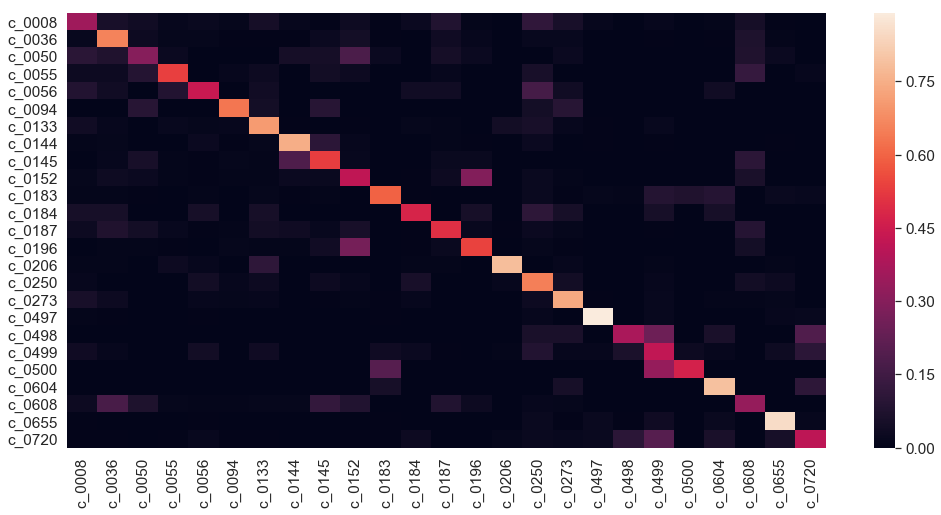

In [43]:
class_names = np.unique(y_train)
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, range(25),range(25))
le_name_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
df_cm.index = df_cm.index.map(le_name_mapping)
df_cm.columns = df_cm.columns.map(le_name_mapping)
plt.figure(figsize=(17, 8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=False,annot_kws={"size": 16})# font size

In [44]:
pd.Series(np.diag(df_cm), index=[df_cm.index])

c_0008    0.354344
c_0036    0.660542
c_0050    0.300000
c_0055    0.535211
c_0056    0.440000
c_0094    0.636364
c_0133    0.706271
c_0144    0.750617
c_0145    0.530645
c_0152    0.419481
c_0183    0.597403
c_0184    0.473684
c_0187    0.503891
c_0196    0.540541
c_0206    0.782946
c_0250    0.652174
c_0273    0.738510
c_0497    0.890302
c_0498    0.375000
c_0499    0.422343
c_0500    0.466667
c_0604    0.789474
c_0608    0.333106
c_0655    0.854839
c_0720    0.415663
dtype: float64